In [55]:
import sys
import findspark
import pyspark
!pip install folium
import folium
import math
import numpy as np
WhoIsWorking="Daan"
if(WhoIsWorking=="Daan"):
    findspark.init("c:/Users/Eigenaar/spark-3.1.2-bin-hadoop3.2")
else:
    findspark.init("C:\\spark-3.1.2-bin-hadoop3.2\\spark-3.1.2-bin-hadoop3.2")

You should consider upgrading via the 'c:\users\eigenaar\anaconda3\python.exe -m pip install --upgrade pip' command.


In [56]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import avg
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from pyspark.sql.functions import col
from collections import Counter
from pyspark.sql.functions import count
from folium.plugins import HeatMap
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pyspark.sql.functions import year, month, dayofmonth, substring




In [57]:
spark = SparkSession.builder.getOrCreate()

# Inleiding

In dit onderzoek zal worden getracht om een verband te zoeken tussen de locaties van pubs en de locaties van accidenten in het Verenigd Koninkrijk.
De gebruikte accidenten en casualties data komen beide van Kaggle: https://www.kaggle.com/benoit72/uk-accidents-10-years-history-with-many-variables . De dataset van de pubs komt ook van Kaggle. Verder wordt er, tijdens het onderzoek, ook gebruik gemaakt van datasets over bijvoorbeeld alcohol  blaastesten die werden genomen na een accident. Deze datasets zijn terug te vinden op https://www.gov.uk/government/statistical-data-sets/reported-drinking-and-driving-ras51 


# Data exploratie

### Data importeren
pubs data, accidenten data en casualties data importeren

In [58]:

#Creating schema's
schema_pubs = StructType([
    StructField("Food Standard Agency's ID", StringType(), nullable=True),
    StructField("name", StringType(), nullable=True),
    StructField("address", StringType(), nullable=True),
    StructField("postcode", StringType(), nullable=True),
    StructField("easting", DoubleType(), nullable=True),
    StructField("northing", DoubleType(), nullable=True),
    StructField("latitude", DoubleType(), nullable=False),
    StructField("longitude", DoubleType(), nullable=False),
    StructField("local_authority", StringType(), nullable=True)

])

In [59]:
# importing data 

### casualtiesData_df geeft meer info over het slachtoffer
if(WhoIsWorking=="Daan"):
    casualtiesData_df = spark.read.format('csv').option('header', True).load('Kaggle_datasets/Casualties0514.csv')
    accidentData_df = spark.read.format('csv').option('header',True).load('Kaggle_datasets/Accidents0514.csv')
    pubsData_df = spark.read.format('csv').option('header',False).schema(schema_pubs).load('open_pubs.csv')
else:
    accidentData_df = spark.read.format('csv').option('header',True).load('../../../Desktop/Data mining/Accidents0514.csv')
    pubsData_df = spark.read.format('csv').option('header',False).schema(schema_pubs).load('open_pubs.csv')
    casualtiesData_df = spark.read.format('csv').option('header', True).load('../../../Desktop/Data mining/Casualties0514.csv')

Records met lege values eruit halen. Hier worden ook kolommen gedropt die volgens ons weing zullen bijdragen tot het onderzoek of waarmee wij geen belangrijke diagram mee kunnen maken. 

In [60]:
### Filter de pub data set
counterRowsBeforePubs=pubsData_df.count()
pubsData_df=pubsData_df.dropna(subset=["latitude","longitude"])
print(counterRowsBeforePubs-pubsData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")
### nutteloze kolommen zoals Pedestrian_Crossing,Special_Condition_at_site, Carriageway_Hazards,  want volgens Kaggle hebben bijna alle records dezelfde data dus veel gaat deze kolom ons niet opleveren alleen maar een langere run time. heb ook Location_Northing_OSGR, Location_Easting_OSGR, Local_Authority_(District), Local_Authority_(Highway)1st_Road_Class, 1st_Road_Number, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities
accidentData_df = accidentData_df.drop("Pedestrian_Crossing", "Special_Condition_at_site","Local_Authority_(Highway)", "Carriageway_Hazards","Location_Northing_OSGR", "Location_Easting_OSGR", "Local_Authority_(District)", "Local_Authority_(Highway)1st_Road_Class", "1st_Road_Number", "2nd_Road_Class", "2nd_Road_Number", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities")
### In casualtiesData heb ik ook een paar kolommen verwijderd => Pedestian_Location, Pedestrian_Movement, Bus_or_Coach_, Vehicle_Reference, Casualty_Reference, Age_Band_of_Casualty, Pedestrian_Road_Maintenance_Worker, Casualty_Home_Area_Type
casualtiesData_df = casualtiesData_df.drop("Pedestian_Location", "Pedestrian_Movement", "Bus_or_Coach_Passenger", "Vehicle_Reference", "Casualty_Reference", "Age_Band_of_Casualty", "Pedestrian_Road_Maintenance_Worker","Casualty_Home_Area_Type" )
print("Kolommen Vehicle_Reference en Casualty_Reference zijn zeer nuttige gegevens maar die waarden komen precies niet overeen met die tabel op Kaggle dus heb ze weggelaten. Kan dat ik verkeerd ben maar heb niets gevonden.")


146  rijen zijn verwijderd omdat ze lege waarden hadden.
Kolommen Vehicle_Reference en Casualty_Reference zijn zeer nuttige gegevens maar die waarden komen precies niet overeen met die tabel op Kaggle dus heb ze weggelaten. Kan dat ik verkeerd ben maar heb niets gevonden.


In [61]:
### Filter de accident data set
counterRowsBeforePubs=accidentData_df.count()
accidentData_df=accidentData_df.na.drop()
print(counterRowsBeforePubs-accidentData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")

### Filter de casaulties data
counterRowsBeforeCasaul=casualtiesData_df.count()
casualtiesData_df=casualtiesData_df.na.drop()
print(counterRowsBeforeCasaul-casualtiesData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")


120599  rijen zijn verwijderd omdat ze lege waarden hadden.
0  rijen zijn verwijderd omdat ze lege waarden hadden.


### Data transformatie

Hier worden datadrame van de accidenten en casualties gejoined in één dataframe

In [63]:
### twee dataframes in één dataframe joinen m.b.v. ID(Accident_Index). Beide dataframes hebben evenveel records.
joined = accidentData_df.alias("A").join(casualtiesData_df.alias("B"),col("A.Accident_Index") == col("B.Accident_Index"),"inner").select(col("A.Accident_Index"), col("A.Longitude"),col("A.Latitude"), col("A.Police_Force"), col("A.Accident_Severity"), col("A.Number_of_Vehicles"), col("A.Number_of_Casualties"), col("A.Date"), col("A.Day_of_Week"),col("A.Time"), col("A.1st_Road_Class"), col("A.Road_Type"), col("A.Speed_limit"), col("A.Junction_Detail"), col("A.Junction_Control"), col("A.Light_Conditions"), col("A.Weather_Conditions"), col("A.Road_Surface_Conditions"), col("A.Special_Conditions_at_Site"), col("A.Urban_or_Rural_Area"), col("A.Did_Police_Officer_Attend_Scene_of_Accident"), col("A.LSOA_of_Accident_Location"), col("B.Casualty_Class"), col("B.Sex_of_Casualty"), col("B.Age_of_Casualty"), col("B.Casualty_Severity"), col("B.Pedestrian_Location"), col("B.Car_Passenger"), col("B.Casualty_Type")).toDF("Accident_Index", "Longitude","Latitude","Police_Force", "Accident_Severity","Number_of_Vehicles", "Number_of_Casualties", "Date", "Day_of_Week","Time","1st_Road_Class", "Road_Type", "Speed_limit","Junction_Detail", "Junction_Control","Light_Conditions", "Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site","Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident", "LSOA_of_Accident_Location","Casualty_Class","Sex_of_Casualty","Age_of_Casualty","Casualty_Severity","Pedestrian_Location","Car_Passenger","Casualty_Type")

#### Leeftijd categoriseren en nieuwe kolommen toevoegen

Omdat de leeftijd werd meegegeven, kunnen wij later tijdens het visualiseren van onze data heel interessante grafieken plotten op basis van de leeftijd. Wij moeten natuurlijk eerst de leeftijden categoriseren. De leeftijdsgroepen die wij hebben gekozen zijn [16-19], [20-24], [25-29], [30-34], [35-39], [40-49], [50-59], [60-69] en [+70] omdat de datasets van https://www.gov.uk/government/statistical-data-sets/reported-drinking-and-driving-ras51 ook deze leeftijdsgroepen gebruiken.

Verder zullen ook kolommen 'Maand' en 'Jaar' worden toegevoegd aan onze dataframe zodat wij hiermee bijvoorbeeld tijdens het visualiseren van de data kunnen filteren op tijd.

In [64]:
joined = joined.withColumn("Age_of_Casualty", col("Age_of_Casualty").cast("int"))
def sort_age(age):
    age = int(age)
    if 16 <= age < 20:
        return "1"
    elif 20 <= age < 25:
        return "2"
    elif 25<=age <30:
        return "3"
    elif 30<= age <35:
        return "4"
    elif 35<= age <40:
        return "5"
    elif 40<= age <50:
        return "6"
    elif 50 <= age <60 :
        return "7"
    elif 60 <= age <70:
        return "8"
    elif age <= 70:
        return "9"
    else:
        return "10"

def get_jaar(datum):
    return(datum[-4:]) 
def get_maand(datum):
    return(datum[3:5])

joined = joined.withColumn("Age_of_Casualty", col("Age_of_Casualty").cast("int"))
joined = joined.withColumn("Date", col("Date").cast("String"))
joined = joined.withColumnRenamed("1st_Road_Class", "First_Road_Class")
joined2 = joined.rdd.map(lambda x: (x.Accident_Index, x.Longitude, 
                                    x.Latitude, x.Police_Force, x.Accident_Severity, x.Number_of_Vehicles, 
                                    x.Number_of_Casualties, x.Date, x.Day_of_Week, x.Time, x.First_Road_Class, 
                                    x.Road_Type, x.Speed_limit, x.Junction_Detail, x.Junction_Control, x.Light_Conditions, 
                                    x.Weather_Conditions,
                                    x.Road_Surface_Conditions, x.Special_Conditions_at_Site,
                                    x.Urban_or_Rural_Area, x.Did_Police_Officer_Attend_Scene_of_Accident, x.LSOA_of_Accident_Location, x.Casualty_Class, x.Sex_of_Casualty, x.Age_of_Casualty, x.Casualty_Severity, x.Pedestrian_Location, x.Car_Passenger, x.Casualty_Type, sort_age(x.Age_of_Casualty), get_jaar(x.Date), get_maand(x.Date)))

joined2 = joined2.toDF(["Accident_Index", "Longitude" , "Latitude" , "Police_Force" , "Accident_Severity" ,
       "Number_of_Vehicles" , "Number_of_Casualties" , "Date" , "Day_of_Week" , "Time" , "1st_Road_Class" , "Road_Type" , "Speed_limit" , "Junction_Detail" , "Junction_Control" , "Light_Conditions" , "Weather_Conditions" , "Road_Surface_Conditions" , "Special_Conditions_at_Site" , "Urban_or_Rural_Area" ,
       "Did_Police_Officer_Attend_Scene_of_Accident" , "LSOA_of_Accident_Location" , "Casualty_Class" , "Sex_of_Casualty" , 
       "Age_of_Casualty" , "Casualty_Severity" , "Pedestrian_Location" , "Car_Passenger" , "Casualty_Type" , "Age_Cat", "Jaar", "Maand"])

In [65]:
joined2.groupby("Casualty_Class").count().show()

+--------------+-------+
|Casualty_Class|  count|
+--------------+-------+
|             3| 251398|
|             1|1307284|
|             2| 499897|
+--------------+-------+



#### Casualty_Class

De kolom "Casualty_Class" kan waarde "1", "2" of "3" aannemen. Deze waarden geven aan wat de rol, van de persoon in kwestie, was tijdens het accident. 1 = "Driver or rider", 2 = "Passenger", 3 = "Pedestrian". Passagiers kunnen heel moeilijk de oorzaak zijn van een accident en daarom verwijderen wij alle passagiers uit onze dataframe. Dit zal later tijdens het visualiseren van onze data ook voor een minder lange run time zorgen.

In [66]:
joined2 = joined2.where(col("Casualty_Class") != 2)

In [67]:
joined2.groupby("Age_of_Casualty").count().show(5)

+---------------+-----+
|Age_of_Casualty|count|
+---------------+-----+
|             26|36351|
|             29|31700|
|             65| 8237|
|             19|47267|
|             54|15922|
+---------------+-----+
only showing top 5 rows



#### Leeftijd

Aangezien wij opzoek zijn naar accidenten die werden veroorzaakt door mensen onder invloed van alcohol, lijkt het ons logisch dat wij de records van kinderen onder de 16 uit onze dataframe halen. De datesets die wij hebben gevonden op https://www.gov.uk/government/statistical-data-sets/reported-drinking-and-driving-ras51 , gaan ook enkel over mensen die ouder zijn dan 16. Dus een extra reden om kinderen uit onze dataframe te halen.

In [68]:
joined2 = joined2.where(col("Age_of_Casualty") >= 16)

In [69]:
joined2.groupby("Casualty_Type").count().show(20)

+-------------+------+
|Casualty_Type| count|
+-------------+------+
|           11|  5229|
|            3| 61006|
|            8| 13544|
|           22|   328|
|           16|   909|
|            0|168454|
|           98|    37|
|            5| 74427|
|           18|    10|
|           17|   869|
|           90|  6433|
|           19| 34772|
|           23|    15|
|           97|   165|
|            9|857491|
|            1|136329|
|           20|  4203|
|           10|  1949|
|            4| 20474|
|           21|  9781|
+-------------+------+
only showing top 20 rows



#### Causualty_Type

De datasets die wij hebben gevonden op https://www.gov.uk/government/statistical-data-sets/reported-drinking-and-driving-ras51 gaan elke over voetgangers, motorfietsen en autos. In onze dataframe zijn er ook andere voertuigen aanwezig zoals 10-tonners, paarden, trammen en nog veel andere vervoersmiddelen die niet in onze dataframe horen. Deze halen wij er dus uit.

In [75]:
joined2 = joined2.where(col("Casualty_Type") != 8)
joined2 = joined2.where(col("Casualty_Type") != 10)
joined2 = joined2.where(col("Casualty_Type") != 11)
joined2 = joined2.where(col("Casualty_Type") != 16)
joined2 = joined2.where(col("Casualty_Type") != 17)
joined2 = joined2.where(col("Casualty_Type") != 18)
joined2 = joined2.where(col("Casualty_Type") != 19)
joined2 = joined2.where(col("Casualty_Type") != 20)
joined2 = joined2.where(col("Casualty_Type") != 21)
joined2 = joined2.where(col("Casualty_Type") != 23)
joined2 = joined2.where(col("Casualty_Type") != 90)
joined2 = joined2.where(col("Casualty_Type") != 97)
joined2 = joined2.where(col("Casualty_Type") != 98)

# Data visualiseren

In dit deel van het onderzoek zal de data worden gevisualiseerd door betekenisvolle diagrammen en interactieve maps.

In [76]:
#Creating Table
pubsData_df.registerTempTable('pubsTable')
accidentData_df.registerTempTable('accidentTable')
casualtiesData_df.registerTempTable('casualtiesTable')
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)#Running Query
#Running Query
df1 = sqlContext.sql("SELECT COUNT(local_authority) as count,local_authority from pubsTable group by local_authority order by count")
df2 = sqlContext.sql("SELECT COUNT(Number_of_Casualties) as count_casulties,SPEED_LIMIT FROM accidentTable group by SPEED_LIMIT order by SPEED_LIMIT")
## type sql dataframe .collect to get list

[4, 2, 16160, 983411, 128365, 49398, 229611, 113047]


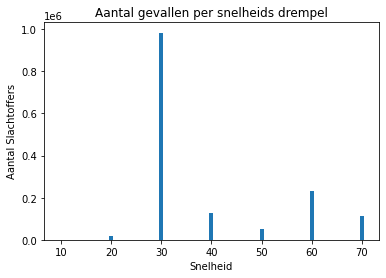

In [77]:
list_casulties_speed=[]
list_speed_casulties=[]
for x in df2.collect():
    list_casulties_speed.append(x[0])
    list_speed_casulties.append(int(x[1]))
print(list_casulties_speed)
plt.bar(list_speed_casulties,list_casulties_speed)
plt.title("Aantal gevallen per snelheids drempel")
plt.xlabel('Snelheid')
plt.ylabel('Aantal Slachtoffers')
plt.show()

Uit het bovenstaande diagram kunnen wij concluderen dat de meeste accindenten gebeuren op wegen waar de maximale toegelaten snelheid 30 mph is, dus vooral binnen de bebouwde kom.

In [78]:
local_authority=[]
for row in df1.orderBy("local_authority").collect():
    local_authority.append(row.local_authority)


In [79]:
choose_local_authority = widgets.Dropdown(
    options=local_authority,
    value='Isles of Scilly',
    description='Authority:',
)

def load_map_points(local_authority):
    df1 = sqlContext.sql("SELECT * from pubsTable where local_authority='"+local_authority+"'")
    print(type(df1))
    maxLat=str(df1.agg({"latitude": "max"}).collect()[0][0])
    minLat=str(df1.agg({"latitude": "min"}).collect()[0][0])
    maxLot=str(df1.agg({"longitude": "max"}).collect()[0][0])
    minLot=str(df1.agg({"longitude": "min"}).collect()[0][0])
    print(maxLat[0:4],minLat)
    #LatLong = sqlContext.sql("Select CAST(SUBSTRING(Latitude,0,4) AS float) as fLatitude, CAST(CASE when SUBSTRING(Longitude,0,1)='-' then SUBSTRING(Longitude,0,5) else SUBSTRING(Longitude,0,4)end AS float) as fLongitude FROM accidentTable")
    LatLong = sqlContext.sql("Select CAST(Latitude AS float) as fLatitude, CAST(Longitude AS float) as fLongitude FROM accidentTable where (Latitude like '%"+minLat[0:3]+"%' or Latitude like '%"+maxLat[0:3]+"%') and (Longitude like '%"+minLot[0:3]+"%' or Longitude like '%"+maxLot[0:3]+"%')")
    LatLong.show()
    df1=df1.collect()
    local_authority_coordinates = (df1[0].latitude,df1[0].longitude)
    map = folium.Map(location=local_authority_coordinates, zoom_start=11.5)
    HeatMap(LatLong.collect()).add_to(map)

    ## testing 
    counter=0
    for row in df1:
        folium.Marker(location = [row.latitude,row.longitude],popup=row.name).add_to(map)
    display(map)
def on_change(change):
    load_map_points(change)
interact(on_change, change=choose_local_authority);

interactive(children=(Dropdown(description='Authority:', index=164, options=('Aberdeen City', 'Aberdeenshire',…

Hierboven zien we een map met alle café's van een geslecteerde lokale overheid (vergelijkbaar met gemeente van België). Met alle accidenten die in de buurt zijn gebeurt van 2005-2014. Je kan bij vele gemeentes zien dat de ongevallen vaaker gebeuren in de buurt van café's maar dat is niet overal. 

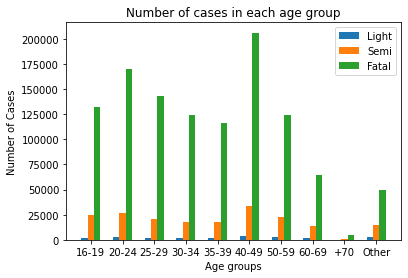

In [80]:
joined2 = joined2.withColumn("Accident_Severity", col("Accident_Severity").cast("int"))
joined2 = joined2.withColumn("Age_Cat", col("Age_Cat").cast("int"))
cat2 = joined2.groupby("Age_Cat", "Accident_Severity").count().toDF("Age_Cat", "Accident_Severity", "count").sort("Age_Cat","Accident_Severity")
X = ["16-19", "20-24", "25-29", "30-34", "35-39", "40-49", "50-59", "60-69", "+70", "Other"]
light = []
semi = []
fatal = []
for x in cat2.collect():
    if x[1] == 1:
        light.append(x[2])
    elif x[1] == 2:
        semi.append(x[2])
    else:
        fatal.append(x[2])
      


X_axis = np.arange(len(X))
plt.bar(X_axis-0.2, light,0.2, label = 'Light')
plt.bar(X_axis, semi,0.2, label = 'Semi')
plt.bar(X_axis+0.2, fatal,0.2, label = 'Fatal')
   
plt.xticks(X_axis, X)
plt.xlabel("Age groups")
plt.ylabel("Number of Cases")
plt.title("Number of cases in each age group")
plt.legend()
plt.show()

Het bovenstaande diagram geeft het aantal accidenten voor per leeftijdscategorie en per ernstheid van het accident.

###### Kijken naar de accidenten doorheen de tijd

In [81]:
ListOfYears=sqlContext.sql("SELECT Day_of_Week from accidentTable group by Day_of_Week").collect()
Yearslider=widgets.IntSlider(
    min=min(ListOfYears)[0],
    max=max(ListOfYears) [0],
    description='Day:',
)
intresantColoms=("Police_Force","Accident_Severity","Number_of_Vehicles","Number_of_Casualties")
def f(x):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig, axs = plt.subplots(math.ceil((len(intresantColoms)/2)),2)
    fig.suptitle('Het aantal voertuigen, gewonden, ergte en politie aanwezigen per soort voor Dag:'+str(x))
    for indx,onderwerp in enumerate(intresantColoms):
        ListOfDays=sqlContext.sql("SELECT "+onderwerp+",count("+onderwerp+") as aantal from accidentTable where Day_of_Week="+str(x)+" group by "+onderwerp+" order by "+onderwerp).collect()
        NumberList=[]
        BarList=[]
        for row in ListOfDays:
            NumberList.append((row[0]))
            BarList.append(row[1])
        axs[math.ceil(indx/2)-1,indx%2].bar(NumberList,BarList)
        axs[math.ceil(indx/2)-1,indx%2].set_title(onderwerp)
    return x
interact(f, x=Yearslider);

interactive(children=(IntSlider(value=1, description='Day:', max=7, min=1), Output()), _dom_classes=('widget-i…

###### Ongevallen per leeftijds categorie van de verongelukte op omgevings factoren

interactive(children=(IntSlider(value=0, description='Age:', max=99, min=-1), Output()), _dom_classes=('widget…

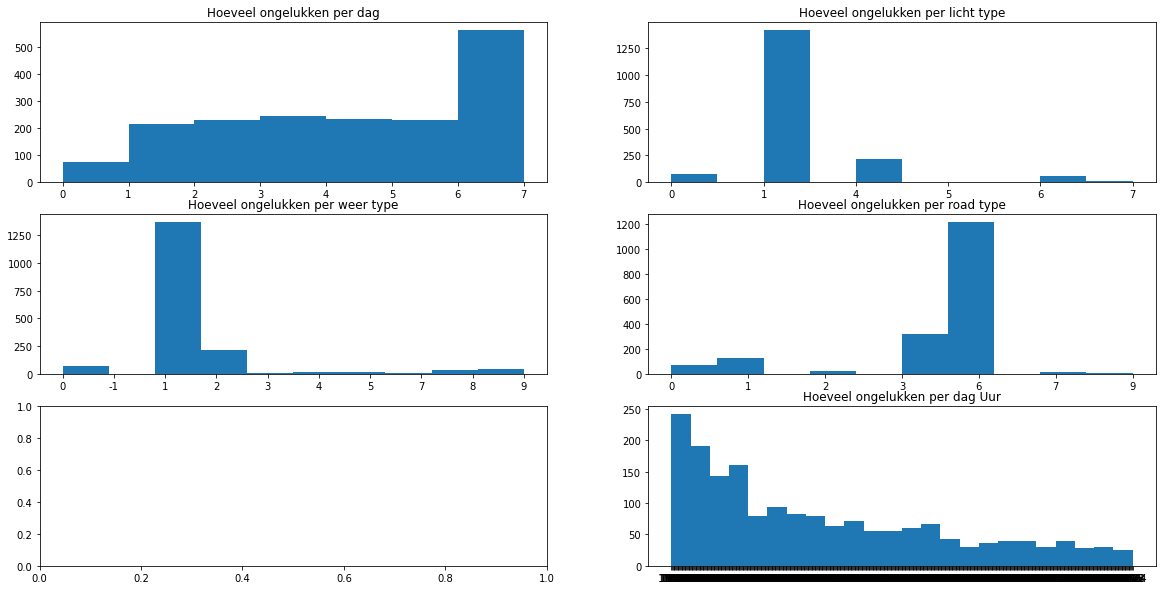

In [82]:
joinAccidentsCasulties = sqlContext.sql('SELECT * from accidentTable right join casualtiesTable on casualtiesTable.Accident_Index==accidentTable.Accident_Index')
ListAccidentsCasulties=joinAccidentsCasulties.select("Age_of_Casualty").distinct().sort("Age_of_Casualty").collect()

Ageslider=widgets.IntSlider(
    min=min(ListAccidentsCasulties)[0],
    max=max(ListAccidentsCasulties)[0],
    description='Age:',
)
intresantColoms=("Light_Conditions","Weather_Conditions","Road_Type","Time","Day_of_Week")

def createArray(dictionary):
    values=[]
    for row in dictionary:
        if not(row[0]==None):
            values.append(row[0])
        else:
            values.append(0)
    return values

def f(x):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig, axs = plt.subplots(3,2)
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[4]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[4]).collect()
    axs[0,0].hist(createArray(colomForGraph),density=False, bins=7)
    axs[0,0].set_title("Hoeveel ongelukken per dag")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[0]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[0]).collect()
    axs[0,1].hist(createArray(colomForGraph))
    axs[0,1].set_title("Hoeveel ongelukken per licht type")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[1]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[1]).collect()
    axs[1,0].hist(createArray(colomForGraph))
    axs[1,0].set_title("Hoeveel ongelukken per weer type")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[2]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[2]).collect()
    axs[1,1].hist(createArray(colomForGraph))
    axs[1,1].set_title("Hoeveel ongelukken per road type")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[3]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[2]).collect()
    axs[2,1].hist(createArray(colomForGraph), bins=24)
    axs[2,1].set_title("Hoeveel ongelukken per dag Uur")
    fig.delaxes(axs[2,2])
    return x
interact(f, x=Ageslider);

In [83]:
sev = ["1", "2", "3"]
jaar = ["2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014"]
maand = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
choose_age_cat = widgets.Dropdown(options = X, value="16-19", description="Age Group:")
choose_severity = widgets.Dropdown(options = sev, value="1", description="Severity:")
choose_jaar = widgets.Dropdown(options = jaar, value="2005", description="Year:")
choose_maand = widgets.Dropdown(options = maand, value="01", description="Month:")
joined2 = joined2.withColumn("Age_Cat", col("Age_Cat").cast("String"))
def load_map_acc(age_cat, severity, jaar, maand):
    dfa = sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat="+age_cat+" AND Casualty_Severity="+severity+" AND Jaar ='"+jaar+"' AND Maand='"+maand+"'")
    coo = (dfa.collect()[0].Latitude, dfa.collect()[0].Longitude)
    mapa = folium.Map(location = coo, zoom_start=11.5)
    for row in dfa.collect():
        folium.Marker(location= [row.Latitude, row.Longitude], popup = row.Accident_Index).add_to(mapa)
    display(mapa)
joined2.createOrReplaceTempView("joined2")
load_map_acc("1","2", "2006","01")

KeyboardInterrupt: 

nog bezig 

##### Gemiddelde afstand dichstbezijne bar en ongeval
Gebruik maken van Haversine formula formule

In [121]:
import pandas
df = pandas.read_excel('Drink_and_drive_data/ras51019.xlsx', sheet_name='2019')
Region_Boundaries = spark.read.format('json').load('GeoJson/us-states.json')
["Fatal","Serious","Serious","Slight"]
sparkDF=spark.createDataFrame(df[7:19]) 

sparkDF = sparkDF.withColumnRenamed("Unnamed: 1","Fatal Accidents")\
    .withColumnRenamed("Unnamed: 2","Serious (unadjusted) Accidents")\
    .withColumnRenamed("Unnamed: 3","Serious (adjusted) Accidents")\
    .withColumnRenamed("Unnamed: 4","Slight (unadjusted) Accidents")\
    .withColumnRenamed("Unnamed: 5","Slight (adjusted) Accidents")\
    .withColumnRenamed("Unnamed: 6","Total Accidents")\
    .withColumnRenamed("Unnamed: 8","Killed Casualties")\
    .withColumnRenamed("Unnamed: 9","Seriously injured (unadjusted) Casualties")\
    .withColumnRenamed("Unnamed: 10","Seriously injured  (adjusted) Casualties")\
    .withColumnRenamed("Unnamed: 11","Killed or seriously injured (unadjusted) Casualties")\
    .withColumnRenamed("Unnamed: 12","Killed or seriously injured (adjusted) Casualties")\
    .withColumnRenamed("Unnamed: 13","Slightly injured (unadjusted) Casualties")\
    .withColumnRenamed("Unnamed: 14","Slightly injured (adjusted) Casualties")\
    .withColumnRenamed("Unnamed: 15","Total Casualties")
sparkDF = sparkDF.drop("Unnamed: 7")
Region_Boundaries.show(5,vertical=True)


-RECORD 0-------------------------------
 _corrupt_record | {"type":"FeatureC... 
 geometry        | null                 
 id              | null                 
 properties      | null                 
 type            | null                 
-RECORD 1-------------------------------
 _corrupt_record | null                 
 geometry        | {[[[-87.359296, 3... 
 id              | AL                   
 properties      | {Alabama}            
 type            | Feature              
-RECORD 2-------------------------------
 _corrupt_record | null                 
 geometry        | {[[[[-131.602021,... 
 id              | AK                   
 properties      | {Alaska}             
 type            | Feature              
-RECORD 3-------------------------------
 _corrupt_record | null                 
 geometry        | {[[[-109.042503, ... 
 id              | AZ                   
 properties      | {Arizona}            
 type            | Feature              
-RECORD 4-------

In [131]:
map_hooray = folium.Map(location=[51.5074, 0.1278],
                        zoom_start = 9)
rdd = spark.read.text("GeoJson/us-states.json")
file = open("GeoJson/Region_Boundaries.geojson.json")
line = file.read()
file.close()
folium.Choropleth(
    geo_data=line,
    name="choropleth",
    data=sparkDF.select("Department for Transport statistics","Total Casualties").collect(),
    columns=["Department for Transport statistics","Total Casualties"],
    key_on="feature.properties.name",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Accidents %",
).add_to(map_hooray)
display(map_hooray)

<class 'str'>
